In [ ]:
'''
全球地震数据处理
在本问题集中，我们将使用美国地质调查局（USGS）地震数据库中的该文件。该数据集与你在《作业 02》中使用的数据集类似。
请使用提供的文件（usgs_earthquakes.csv）重现以下地图，并以 mag 列为震级数据。【10 分】
'''

![earthquakes](./earthquakes.png)

是否均为2014年： True


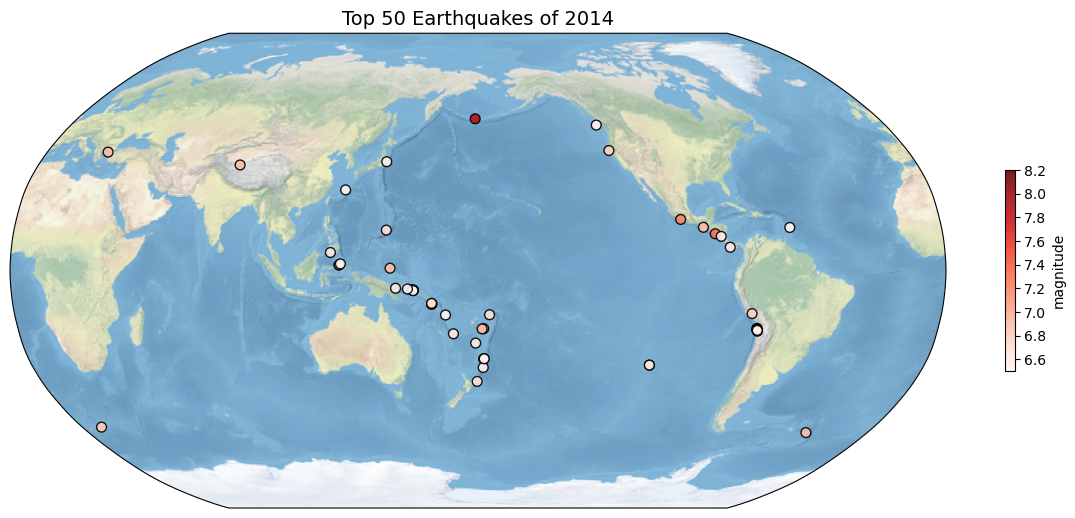

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter

earthquake_mag = pd.read_csv("usgs_earthquakes.csv")
earthquake_mag = earthquake_mag.sort_values('mag', ascending=False).head(50)
earthquake_mag
#是否均为2014年：
print("是否均为2014年：", (pd.to_datetime(earthquake_mag['time'], errors='coerce').dt.year == 2014).all())

fig = plt.figure(figsize=(12, 7)) 
ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180))  #中心
ax.stock_img() 
ax.set_title(f'Top 50 Earthquakes of 2014', fontsize=14 )

scatter = ax.scatter(
    x=earthquake_mag["longitude"],  
    y=earthquake_mag["latitude"],   
    transform=ccrs.PlateCarree(),   
    s=50,
    c=earthquake_mag["mag"],
    cmap=plt.cm.Reds,  
    vmin=earthquake_mag["mag"].min(),
    vmax=earthquake_mag["mag"].max(),
    edgecolors='black',
    linewidths=1,
    alpha=0.9 
)

cbar = plt.colorbar(
    scatter, 
    ax=ax, 
    shrink=0.3,
    label="magnitude",
    ticks=np.arange(6.6, 8.4, 0.2)  #步长0.2
)
# 设置刻度格式为小数点后1位
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.tight_layout()  
plt.show()    

In [ ]:
'''
探索一个 netCDF 数据集
浏览美国国家航空航天局（NASA）戈达德地球科学数据与信息服务中心（GES DISC）官网，搜索并下载一个你感兴趣的数据集。
也欢迎使用你所在研究组在本习题集中提供的数据，但数据集必须为 netCDF 格式。
本习题集允许复用你在第三次作业（Assignment 03）中使用过的同一数据集。

2.1 全球分布图[10 分] 绘制该变量的全球分布图。图表需包含以下要素（每要素 1 分）：
投影方式、x 轴标签与刻度、y 轴标签与刻度、标题、网格线、图例、颜色条、掩码或地理特征、标注、文本框。

2.2 区域分布图[10 分] 绘制同一变量的区域分布图。图表需包含以下要素（每要素 1 分）：
不同的投影方式、x 轴标签与刻度、y 轴标签与刻度、标题、网格线、图例、颜色条、掩码或地理特征、标注、文本框。
'''

#https://disc.gsfc.nasa.gov/datasets/CMSFluxLandPrior_3/summary
#该数据集是2010-2022年全球逐月陆地净生物圈交换（NBE）先验数据，
#以1°×1°空间分辨率记录生态系统与大气的碳交换强度（负值为碳汇、正值为碳源），用于全球碳循环研究与气候模型校准。

In [45]:
import xarray as xr

ds = xr.open_dataset("CMSFluxLandPrior201001_202212_v3.nc", decode_times=False)

#print(ds)
print(f"数据集维度：{ds.dims}\n核心变量：{list(ds.data_vars.keys())}")

数据集维度：FrozenMappingWarningOnValuesAccess({'time': 156, 'latitude': 180, 'longitude': 360})
核心变量：['NBE_prior', 'area']


In [53]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

ds = xr.open_dataset("CMSFluxLandPrior201001_202212_v3.nc", decode_times=False)
data = ds["NBE_prior"].mean(dim="time")  # 2010-2022年，时间平均的全球NBE_prior

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", 
               add_colorbar=True, cbar_kwargs={"label": "NBE Prior (gC/m²/month)"})  #图例

#标题/坐标轴标签/刻度
ax.set_title("Global Mean NBE Prior (2010-2022)", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7, xlocs=ax.get_xticks(), ylocs=ax.get_yticks())  # 网格线带标签
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)  # 海岸线（地理特征）
ax.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.5)  # 国界线

ax.text(0.02, 0.02, "Projection: PlateCarree (Equidistant Cylindrical)", transform=ax.transAxes, 
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))  # 文本框

ax.legend(["NBE Prior (Carbon Flux)"], loc="upper right", frameon=True, facecolor="white", framealpha=0.8)

ax.annotate("High Flux Region", xy=(-90, 38), xytext=(-70, 24), 
            arrowprops=dict(arrowstyle="->"))  # 标注

plt.tight_layout()
plt.show()

In [59]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset("CMSFluxLandPrior201001_202212_v3.nc", decode_times=False)
data = ds["NBE_prior"].mean(dim="time")  # 时间均值
region_data = data.sel(latitude=slice(20, 50), longitude=slice(100, 145))  # 东亚区域

#改用LambertConformal投影，区别于全球图的PlateCarree
fig, ax = plt.subplots(
    figsize=(7, 5), 
    subplot_kw={"projection": ccrs.LambertConformal(central_longitude=120, central_latitude=35)}
)
im = region_data.plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
    add_colorbar=True, cbar_kwargs={"label": "NBE Prior (gC/m²/month)"}
)

#标题/坐标轴标签/刻度
ax.set_title("East Asia NBE Prior Mean (2010-2022)", fontsize=14)
ax.set_xlabel("Longitude (°E)", fontsize=12)
ax.set_ylabel("Latitude (°N)", fontsize=12)
ax.set_extent([100, 145, 20, 50], crs=ccrs.PlateCarree())  # 区域范围

ax.gridlines(
    draw_labels=True, linestyle="--", alpha=0.7,
    xlocs=[100, 110, 120, 130, 140], ylocs=[20, 30, 40, 50]
)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)  # 海岸线
ax.add_feature(cfeature.BORDERS, linewidth=0.5)    # 国界线
ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.2)  # 陆地掩码

ax.text(0.02, 0.02, "Projection: LambertConformal (Central Lon:120°E, Lat:35°N)", transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))  # 文本框

#ax.legend(["East Asia NBE Prior (Carbon Flux)"], loc="upper right", frameon=True, facecolor="white", framealpha=0.8, fontsize=10)

ax.annotate("China Mainland", xy=(115, 35), xytext=(120, 40),
            arrowprops=dict(arrowstyle="->"), transform=ccrs.PlateCarree())  # 标注

plt.tight_layout()
plt.show()

In [47]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation

# 1. 读取数据+预处理（最后12个月：2022年1-12月）
ds = xr.open_dataset("CMSFluxLandPrior201001_202212_v3.nc", decode_times=False)
data = ds["NBE_prior"].isel(time=slice(-12, None))  # 最后12个月
time_labels = [f"2022-{m:02d}" for m in range(1, 13)]  # 时间标签

# 2. 初始化绘图（指定投影+所有基础要素）
fig, ax = plt.subplots(
    figsize=(14, 8), 
    subplot_kw={"projection": ccrs.PlateCarree()}  # 投影方式
)

# 地理特征/掩码（陆地/海岸线/国界线）
ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.2)  # 陆地掩码
ax.add_feature(cfeature.COASTLINE, linewidth=1.0, color="black")  # 海岸线
ax.add_feature(cfeature.BORDERS, linewidth=0.6, color="gray", alpha=0.7)  # 国界线

# 网格线（带刻度标签）
ax.gridlines(
    draw_labels=True, linestyle="--", alpha=0.8, linewidth=0.8,
    xlocs=[-180, -120, -60, 0, 60, 120, 180],  # x轴刻度
    ylocs=[-60, -30, 0, 30, 60]  # y轴刻度
)

# x/y轴标签（适配PlateCarree投影）
ax.set_xlabel("Longitude (°E)", fontsize=12, labelpad=15)
ax.set_ylabel("Latitude (°N)", fontsize=12, labelpad=20)

# 固定色标范围
vmin, vmax = data.min().values, data.max().values
# 初始帧+颜色条
im = data.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
    add_colorbar=True, cbar_kwargs={
        "label": "NBE Prior (gC/m²/month)",  # 颜色条标签
        "shrink": 0.8, "pad": 0.05
    })

# 标题
title = ax.set_title(
    f"Global Terrestrial Carbon Flux (NBE Prior) - {time_labels[0]}",
    fontsize=16, pad=20
)

# 图例（修复：移除不支持的alpha参数，用framealpha替代）
#ax.legend(
#    loc="upper right", fontsize=11, frameon=True, 
#    facecolor="white", framealpha=0.9  # framealpha控制图例背景透明度
#)

# 文本框
text_box = ax.text(
    0.02, 0.02, "CMSFluxLandPrior v3 | 2010-2022", transform=ax.transAxes,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor="gray"),
    fontsize=10
)

# 3. 帧更新函数（仅更新数据和标题）
def update(frame):
    # 清除旧数据层
    [p.remove() for p in ax.collections if "pcolormesh" in str(p) and p != im.colorbar.outline]
    # 绘制当前帧数据
    data.isel(time=frame).plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r",
        add_colorbar=False, vmin=vmin, vmax=vmax
    )
    # 更新标题
    title.set_text(f"Global Terrestrial Carbon Flux (NBE Prior) - {time_labels[frame]}")
    return [im, title]

# 4. 创建动画
ani = FuncAnimation(
    fig, update, frames=12, interval=400,
    blit=False, repeat=True
)

# 强制渲染（适配Jupyter）
plt.rcParams['animation.html'] = 'jshtml'
display(ani)
plt.close()

'''
负值（蓝色，碳汇）：
    比如亚马逊雨林、东南亚森林、北欧针叶林等区域，植被通过光合作用吸收 CO₂，把碳固定在植物 / 土壤中，相当于地球的 “碳吸尘器”，数值越负，固碳能力越强。
正值（红色，碳源）：
    比如非洲萨赫勒地区、中亚荒漠、部分农业区，土壤呼吸、植被分解、人类活动（如秸秆燃烧）会释放 CO₂到大气，数值越正，释碳量越多。
'''

'\n负值（蓝色，碳汇）：\n    比如亚马逊雨林、东南亚森林、北欧针叶林等区域，植被通过光合作用吸收 CO₂，把碳固定在植物 / 土壤中，相当于地球的 “碳吸尘器”，数值越负，固碳能力越强。\n正值（红色，碳源）：\n    比如非洲萨赫勒地区、中亚荒漠、部分农业区，土壤呼吸、植被分解、人类活动（如秸秆燃烧）会释放 CO₂到大气，数值越正，释碳量越多。\n'